#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


from catboost import CatBoostRegressor

from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from torch import optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import skorch
import random

In [2]:
df = pd.read_csv('C:\\Users\\seryo\\taxi.csv', index_col=[0], parse_dates=[0], dayfirst=True)

# index_col=[0] - столбец, который будет индексом
# parse_dates=[0] - столбец, который мы переводим в формат даты

In [3]:
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В нашем Data Frame 26496 строк и 1 столбец. Тип данных: столбец типа int64.

In [5]:
df = df.resample('1H').sum()

Делаем ресемплирование по одному часу.

In [6]:
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [7]:
df.tail(3)

,num_orders
datetime,
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


В Data Frame заказы начинаются с 2018-03-01 и заканчиваются 2018-08-31

In [8]:
df.max()

num_orders    462
dtype: int64

In [9]:
df.min()

num_orders    0
dtype: int64

In [10]:
df[df['num_orders'] == 0]

,num_orders
datetime,
2018-04-06 06:00:00,0


Максимальное кол-во заказов за 1 час 462, минимальное значение заказов 2018-04-06 06:00:00 составляет 0 заказов, как вариант, возможно был какой-то сбой в системе.

## Анализ

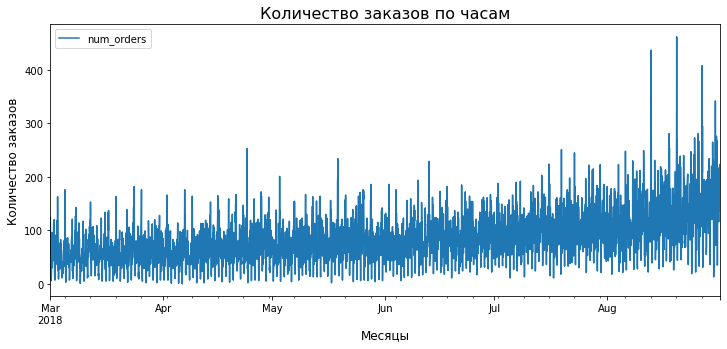

In [11]:
df.resample('1H').sum().plot(figsize=(12, 5))
plt.xlabel("Месяцы", fontsize=12)
plt.ylabel("Количество заказов", fontsize=12)
plt.title('Количество заказов по часам', fontsize=16);

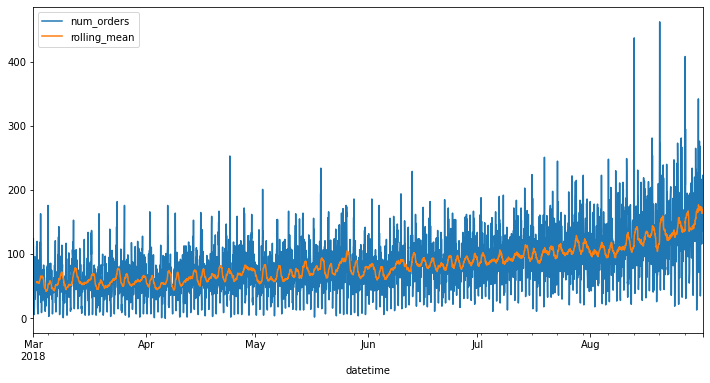

In [12]:
df_rol = df.copy()
df_rol['rolling_mean'] = df_rol.rolling(24).mean() # Cкользящее среднее с окном размером 24
df_rol.plot(figsize=(12,6));

Из графика можно сделать вывод, что к лету кол-во заказов увеличивается, переодически возникают выбросы по кол-ву заказов которые влияют на разброс, возможно это связано с какими-то праздниками или например с плохой погодой. 

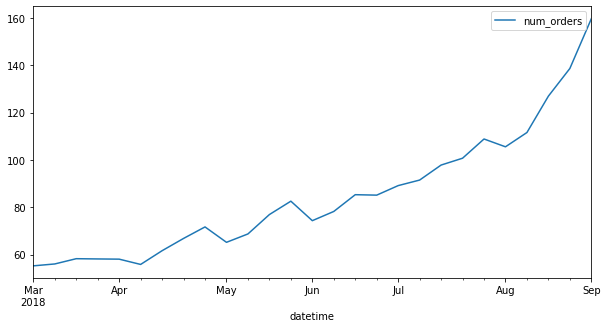

In [13]:
df.resample('W').mean().plot(figsize=(10,5));

Построили график со средним кол-вом заказов по неделям, у нас не стационарный ряд т к меняется среднее кол-во заказов.

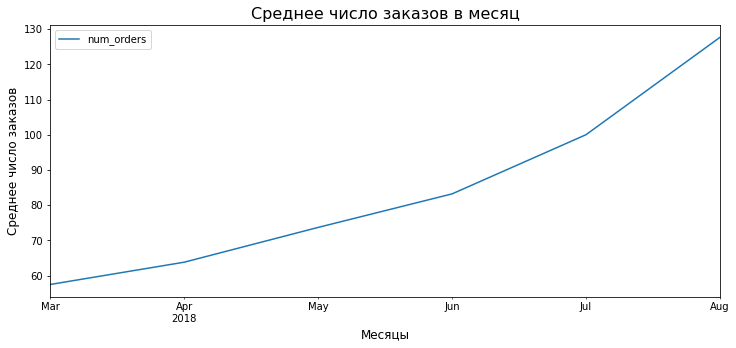

In [14]:
df_month_mean = df.resample('1M').mean()
df_month_mean.plot(figsize=(12, 5))
plt.xlabel("Месяцы", fontsize=12)
plt.ylabel("Среднее число заказов", fontsize=12)
plt.title('Среднее число заказов в месяц', fontsize=16);

С каждым месяцем, число заказов увеличивается

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


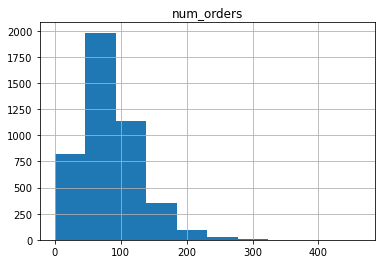

In [15]:
df_describe = df.describe()
df.hist()
df_describe

По графику можно сказать, что в среднем, большее кол-во заказов варьируется примерно от 50 до 90. Как и было написано выше, что max кол-во заказов 462, min кол-во заказов 0. Медиана в районе 84 заказов и среднее кол-во заказов 45. В Data Frame 4416 строк.

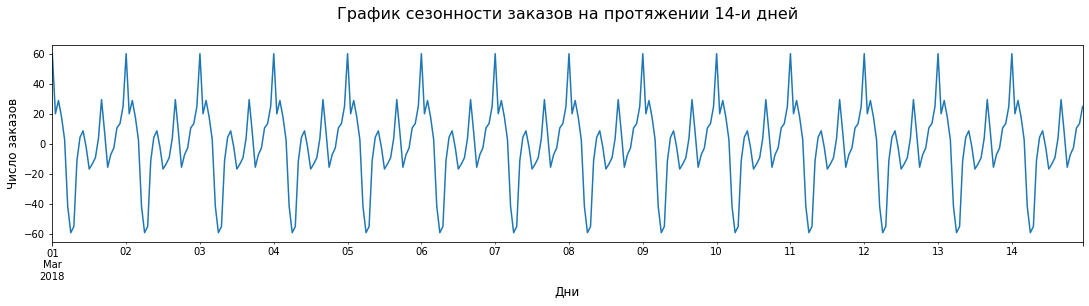

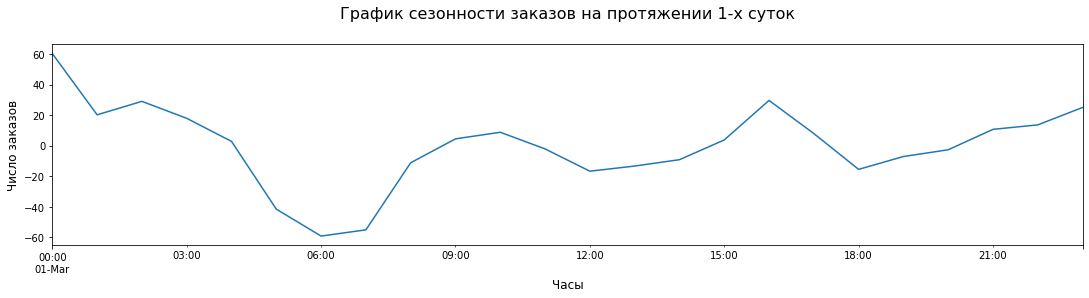

In [16]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))
plt.subplot(313)
plt.title('Seasonality')
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-14 23:59:59'].plot(ax=plt.gca())
plt.tight_layout()
plt.xlabel("Дни", fontsize=12)
plt.ylabel("Число заказов", fontsize=12)
plt.title('График сезонности заказов на протяжении 14-и дней', fontsize=16, y= 1.1);


plt.figure(figsize=(15, 10))
plt.subplot(313)
plt.title('Seasonality')
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-01 23:59:59'].plot(ax=plt.gca())
plt.tight_layout()
plt.xlabel("Часы", fontsize=12)
plt.ylabel("Число заказов", fontsize=12)
plt.title('График сезонности заказов на протяжении 1-х суток', fontsize=16, y= 1.1);

Из графика построенного на 14 дней, ничего особенного в плане заказов выделить нельзя, т к заказы изо дня в день повторяются в примерное кол-ве. Ниже, построен график на одни сутки, из него можно сделать вывод, что пиковые нагрузки в районе 16.00 и после 21.00, после 00.00 кол-во заказов падает.

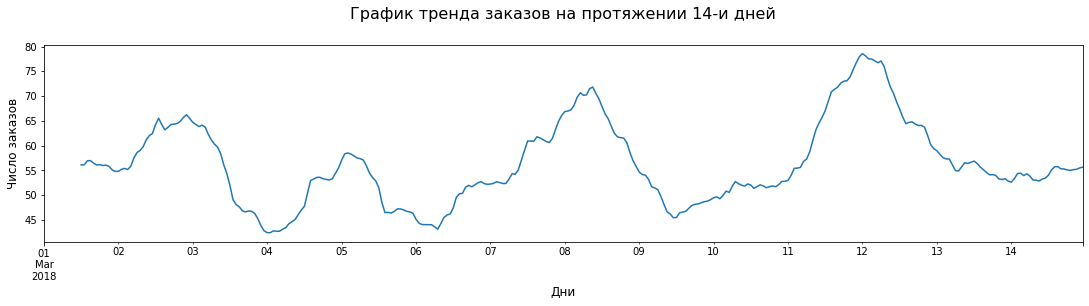

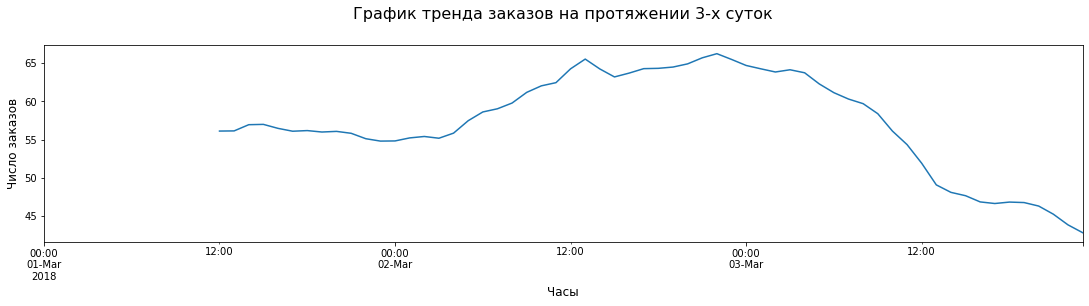

In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(313)
plt.title('Seasonality')
decomposed.trend['2018-03-01 00:00:00':'2018-03-14 23:59:59'].plot(ax=plt.gca())
plt.tight_layout()
plt.xlabel("Дни", fontsize=12)
plt.ylabel("Число заказов", fontsize=12)
plt.title('График тренда заказов на протяжении 14-и дней', fontsize=16, y= 1.1);


plt.figure(figsize=(15, 10))
plt.subplot(313)
plt.title('Seasonality')
decomposed.trend['2018-03-01 00:00:00':'2018-03-03 23:59:59'].plot(ax=plt.gca())
plt.tight_layout()
plt.xlabel("Часы", fontsize=12)
plt.ylabel("Число заказов", fontsize=12)
plt.title('График тренда заказов на протяжении 3-х суток', fontsize=16, y= 1.1);

Из графика тренда по заказам на протяжении 14 дней, можно сделать вывод, что кол-во заказов постепенно увеличивается, опять же, нужно брать во внимание праздник т к в наших графиках есть праздник как 8 марта и последующие выходные и др праздники. Из графика тренда на 3-е суток, вывод один, что кол-во заказов зависит от дня недели, т к в будни кол-во заказов выше, чем в выходные дни.

## Обучение

In [18]:
def make_features(df, max_lag, rolling_mean_size):
    df_ = df.copy()
    
    df_['year'] = df_.index.year
    df_['month'] = df_.index.month
    df_['day'] = df_.index.day
    df_['dayofweek'] = df_.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_['lag_{}'.format(lag)] = df_['num_orders'].shift(lag)

    df_['rolling_mean'] = df_['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_

Написали функцию для подбора гиперпараметров max_lag и rolling_mean_size а так же создаем новые столбца с годом, месяцем, неделей и днем.

### Обучение LinearRegression

In [19]:
%%time
best_max_lag_lr = 0
best_rolling_mean_size_lr = 0
best_rmse_train_lr = 30

for max_lag in range(30, 51, 1):
    for rol_mean_size in range(40, 61, 1):
        df_lin_reg = make_features(df, max_lag, rol_mean_size)

        train_lin, test_lin = train_test_split(df_lin_reg, 
                                               shuffle=False, 
                                               test_size=0.1)  # Разбили Data Frame в соотношении 90 / 10.
        train_lin = train_lin.dropna()

        X_train_lin = train_lin.drop(['num_orders'], axis=1)
        y_train_lin = train_lin['num_orders']

        X_test_lin = test_lin.drop(['num_orders'], axis=1)
        y_test_lin = test_lin['num_orders']

        model_1_0 = LinearRegression()
        scores = abs(cross_val_score(model_1_0, 
                                     X_train_lin, 
                                     y_train_lin, 
                                     cv=TimeSeriesSplit(10),        # default=5
                                     n_jobs = -1,
                                     scoring='neg_root_mean_squared_error')).mean()


        if scores < best_rmse_train_lr:
            best_max_lag_lr = max_lag
            best_rolling_mean_size_lr = rol_mean_size
            best_rmse_train_lr = scores


print(f'Лучшая max_lag = {best_max_lag_lr}', 
      f'Лучшая rolling_mean_size = {best_rolling_mean_size_lr}', 
      f'Лучшая RMSE_train = {best_rmse_train_lr}', sep='\n')

Лучшая max_lag = 44
Лучшая rolling_mean_size = 48
Лучшая RMSE_train = 24.86626342833976
Wall time: 1min 10s


Перебирали гиперпараметры изначально с большим шагом, затем шаг уменьшили, для более точного подбора.

### Обучение CatBoostRegressor


In [20]:
%%time
best_max_lag_cbr = 0
best_rolling_mean_size_cbr = 0
best_rmse_train_cbr = 30

for max_lag in range(1, 22, 5):
    for rol_mean_size in range(70, 91, 5):

        df_cat_bost_reg = make_features(df, max_lag, rol_mean_size)

        train_cbr, test_cbr = train_test_split(df_cat_bost_reg, 
                                               shuffle=False, 
                                               test_size=0.1)  # Разбили Data Frame в соотношении 90 / 10.
        train_cbr = train_cbr.dropna()

        X_train_cbr = train_cbr.drop(['num_orders'], axis=1)
        y_train_cbr = train_cbr['num_orders']

        X_test_cbr = test_cbr.drop(['num_orders'], axis=1)
        y_test_cbr = test_cbr['num_orders']            

        param = {'learning_rate': [0.05, 0.1],
                 'depth' : [4, 7],
                 'n_estimators' : [500, 800]
                }

        model_2 = CatBoostRegressor(loss_function = 'RMSE',                         
                                    random_state = 69,
                                    verbose = False)


        search_2 = HalvingGridSearchCV(model_2, 
                                       param,      
                                       random_state=69, 
                                       cv=TimeSeriesSplit(),   # default=5
                                       n_jobs = -1, 
                                       scoring = 'neg_root_mean_squared_error').fit(X_train_cbr, y_train_cbr)

        if search_2.best_score_ < best_rmse_train_cbr:
            best_max_lag_cbr = max_lag
            best_rolling_mean_size_cbr = rol_mean_size
            best_rmse_train_cbr = search_2.best_score_


print(f'Лучшие гиперпараметры модели {search_2.best_params_}', 
      f'RMSE_train = {abs(search_2.best_score_)}', 
      f'Лучшая max_lag = {best_max_lag_cbr}',
      f'Лучшая rolling_mean_size = {best_rolling_mean_size_cbr}', sep='\n')

Лучшие гиперпараметры модели {'depth': 5, 'learning_rate': 0.05, 'n_estimators': 700}
RMSE_train = 23.42359591251552
Лучшая max_lag = 1
Лучшая rolling_mean_size = 81
Wall time: 6min 24s


### Построение нейронной сети 

In [21]:
%%time

# Делаем наш код повторяемым выдавая одни и те же числа :
random.seed(69)
np.random.seed(69)
torch.manual_seed(69)
torch.use_deterministic_algorithms(True) 


best_max_lag_3 = 0
best_rolling_mean_size_3 = 0
best_n_splits_3 = 0
best_rmse_train_3 = 30


for max_lag_3 in range(30, 51, 5):
    for rol_mean_size_3 in range(10, 31, 5):
        df_neuron = make_features(df, max_lag_3, rol_mean_size_3)
        
        train_neuron, test_neuron = train_test_split(df_neuron, 
                                                     shuffle=False, 
                                                     test_size=0.1)  # Разбили Data Frame в соотношении 90 / 10.
        train_neuron = train_neuron.dropna()

        X_train_neuron = train_neuron.drop(['num_orders'], axis=1)
        y_train_neuron = train_neuron['num_orders']

        X_test_neuron = test_neuron.drop(['num_orders'], axis=1)
        y_test_neuron = test_neuron['num_orders']  
        
        
        # Переводим признаки в torch :
        X_train_df = torch.FloatTensor(X_train_neuron.values)
        X_test_df = torch.FloatTensor(X_test_neuron.values)
        y_train_df = torch.FloatTensor(y_train_neuron.values)
        y_test_df = torch.FloatTensor(y_test_neuron.values)
        
        
        # Переводим target в 2-d массив :
        X_trf = X_train_df
        y_trf = y_train_df.reshape(-1, 1)

        
        class Regressor(nn.Module):
            def __init__(self):
                super(Regressor, self).__init__()

                self.fc1 = nn.Linear(X_train_df.shape[1], 5)        
                self.fc2 = nn.Linear(5, 4)        
                self.fc3 = nn.Linear(4, 3)       
                self.fc4 = nn.Linear(3, 2)
                self.fc5 = nn.Linear(2, 1)

            def forward(self, x):

                x = F.relu(self.fc1(x))
                x = F.relu(self.fc2(x))
                x = F.relu(self.fc3(x))
                x = F.relu(self.fc4(x))      

                return self.fc5(x)


        skorch_regressor = NeuralNetRegressor(module=Regressor, optimizer=optim.Adam, verbose=0)
        
        params = {
            "lr": [0.05, 0.1],
            "max_epochs": [500, 800]
        }

        grid_3 = GridSearchCV(skorch_regressor, 
                              params, 
                              scoring='neg_root_mean_squared_error', 
                              cv=TimeSeriesSplit())

        grid_3.fit(X_trf, y_trf) 
        
        if grid_3.best_score_ < best_rmse_train_3:
            best_max_lag_3 = max_lag_3
            best_rolling_mean_size_3 = rol_mean_size_3
            best_rmse_train_3 = grid_3.best_score_
            
        
print(f'Лучшие гиперпараметры = {grid_3.best_params_}',
      f'RMSE_train = {abs(grid_3.best_score_)}', 
      f'Лучшая max_lag = {best_max_lag_3}',
      f'Лучшая rolling_mean_size = {best_rolling_mean_size_3}', sep='\n')

Лучшие гиперпараметры = {'lr': 0.05, 'max_epochs': 500}
RMSE_train = 30.66661262512207
Лучшая max_lag = 35
Лучшая rolling_mean_size = 25
Wall time: 3h 5min 52s


## Тестирование

In [111]:
def figure_target(test, predict):
    rmse= mse(test, predict)   
   
    plt.figure(figsize=(7, 7))
    plt.plot(predict, test,'o', alpha=0.5)
    plt.text(225,73, f'RMSE = {round(rmse**.5, 2)}')
    plt.xlim(20,300)
    plt.ylim(20,300)
    plt.plot([0,300],[0,300],'--y', linewidth=2)
    plt.title('График отношения предсказанных к истинным значениям', fontsize=16, y=1.05)
    plt.xlabel('Предсказанные значения', fontsize=12, labelpad=10)
    plt.ylabel('Истинные значения', fontsize=12, labelpad=10)
    plt.show()

Функция, для построения среднеквадратичного отклонение на графиках с визуальным распределением разброса целевых признаков.

In [112]:
df_lin_reg_test = make_features(df, best_max_lag_lr, best_rolling_mean_size_lr)

train_lin_test, test_lin_test = train_test_split(df_lin_reg_test, 
                                                 shuffle=False, 
                                                 test_size=0.1)  # Разбили Data Frame в соотношении 90 / 10.
train_lin_test = train_lin_test.dropna()

X_train_lin_test = train_lin_test.drop(['num_orders'], axis=1)
y_train_lin_test = train_lin_test['num_orders']

X_test_lin_test = test_lin_test.drop(['num_orders'], axis=1)
y_test_lin_test = test_lin_test['num_orders']

model_1_test = LinearRegression()
model_1_test.fit(X_train_lin_test, y_train_lin_test)
rmse = mse(y_test_lin_test, model_1_test.predict(X_test_lin_test))** .5
rmse

43.99845693199082

In [113]:
pred_test = model_1_test.predict(X_test_lin_test)

In [114]:
train_rmse = mse(y_train_lin_test, model_1_test.predict(X_train_lin_test))** .5
test_rmse = mse(y_test_lin_test, pred_test)** .5
print(f'Train RMSE: {train_rmse}',
      f'Test RMSE: {test_rmse}', sep='\n')

Train RMSE: 24.119574503816438
Test RMSE: 43.99845693199082


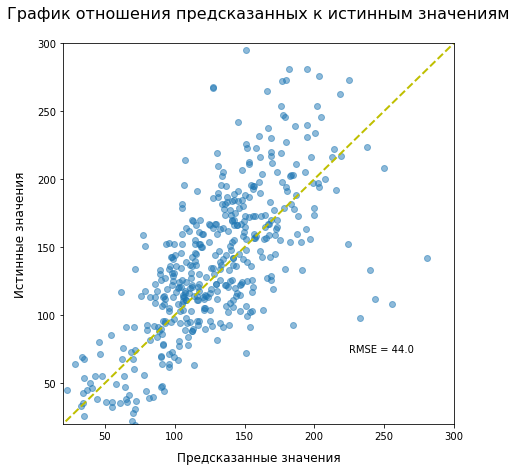

In [115]:
figure_target(y_test_lin_test, pred_test)

## Вывод

В данном проекте, была задача сделать прогноз, на количество заказов такси на следующий час для компании «Чётенькое такси». Так же была поставлена задача, что значение метрики RMSE на тестовой выборке должно быть не больше 48. В нашем случае, на тестовой выборке мы применили LinearRegression, значение метрики RMSE = 44. Обучили несколько моделей с подбором гиперпараметров, разделили тестовую выборку размером 10% от исходных данных. Остановились на результате LinearRegression, т к CatBoostRegressor и нейросеть с перебором гиперпараметров занимает очень много времени.

Виды работ в проекте :

    - Загрузили данные и выполнить их ресемплирование по одному часу.
    - Проанализировали данные.
    - Построили три модели : LinearRegression, CatBoostRegressor и нейросеть.